In [80]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [41]:
# Loading the data
df = pd.read_csv('data.csv', encoding='ISO-8859-1', header=0)

In [44]:
# Displaying the first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [45]:
# Checking dataset shape
df.shape

(541909, 8)

In [46]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [48]:
# Checking percentage of missing values in each column
print("\nPercentage of missing values:\n")
dfnull = round(100 * df.isnull().sum() / len(df), 2)
print(dfnull)


Percentage of missing values:

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64


In [49]:
# Dropping missing values
df = df.dropna()
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (406829, 8)


## Data Preprocessing

In [50]:
# Convert 'CustomerID' to string type
df['CustomerID'] = df['CustomerID'].astype(str)

In [51]:
# Create 'Amount' column
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [52]:
# Calculate Monetary Value (Total amount spent per customer)
gdf = df.groupby('CustomerID')['Amount'].sum().reset_index()
print("\nMonetary value per customer:\n")
print(gdf.head())


Monetary value per customer:

  CustomerID   Amount
0    12346.0     0.00
1    12347.0  4310.00
2    12348.0  1797.24
3    12349.0  1757.55
4    12350.0   334.40


In [53]:
# Calculate Frequency (Number of transactions per customer)
fdf = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
fdf.columns = ['CustomerID', 'Frequency']
print("\nFrequency of transactions per customer:\n")
print(fdf.head())


Frequency of transactions per customer:

  CustomerID  Frequency
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17


In [54]:
# Merging Monetary and Frequency DataFrames
mdf = pd.merge(gdf, fdf, on='CustomerID', how='inner')
print("\nMerged DataFrame (Monetary + Frequency):\n")
print(mdf.head())



Merged DataFrame (Monetary + Frequency):

  CustomerID   Amount  Frequency
0    12346.0     0.00          2
1    12347.0  4310.00        182
2    12348.0  1797.24         31
3    12349.0  1757.55         73
4    12350.0   334.40         17


In [57]:
# Convert date format and find out Max Date for recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
max_date = df['InvoiceDate'].max()
print("\nMax invoice date:", max_date)


Max invoice date: 2011-12-09 12:50:00


In [56]:
# Adding 'Recency' as the difference between max_date and each invoice date
df['Diff'] = max_date - df['InvoiceDate']
mindf = df.groupby('CustomerID')['Diff'].min().reset_index()
mindf['Recency'] = mindf['Diff'].dt.days
print("\nRecency values:")
print(mindf.head())


Recency values:
  CustomerID              Diff  Recency
0    12346.0 325 days 02:33:00      325
1    12347.0   1 days 20:58:00        1
2    12348.0  74 days 23:37:00       74
3    12349.0  18 days 02:59:00       18
4    12350.0 309 days 20:49:00      309


In [ ]:
# Merge Recency with mdf
mdf = pd.merge(mdf, mindf[['CustomerID', 'Recency']], on='CustomerID', how='inner')
print("\nFinal DataFrame with Monetary, Frequency, and Recency:\n")
print(mdf.head())


Final DataFrame with Monetary, Frequency, and Recency:

  CustomerID   Amount  Frequency  Recency_x  Recency_y              Diff  \
0    12346.0     0.00          2        325        325 325 days 02:33:00   
1    12347.0  4310.00        182          1          1   1 days 20:58:00   
2    12348.0  1797.24         31         74         74  74 days 23:37:00   
3    12349.0  1757.55         73         18         18  18 days 02:59:00   
4    12350.0   334.40         17        309        309 309 days 20:49:00   

   Recency  
0      325  
1        1  
2       74  
3       18  
4      309  


### Outlier Detection and Removal

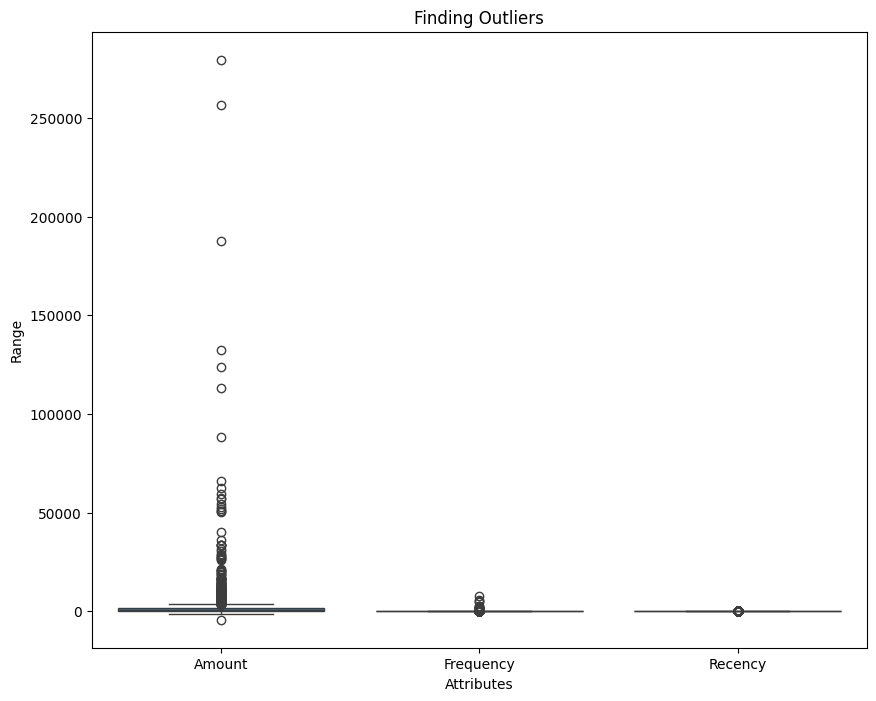

In [61]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(10, 8))
sns.boxplot(data=mdf[['Amount', 'Frequency', 'Recency']])
plt.title("Finding Outliers")
plt.ylabel("Range")
plt.xlabel("Attributes")
plt.show()

In [62]:
# Remove outliers using IQR Method
for column in ['Amount', 'Frequency', 'Recency']:
    q1 = mdf[column].quantile(0.05)
    q3 = mdf[column].quantile(0.95)
    IQR = q3 - q1
    mdf = mdf[(mdf[column] >= (q1 - 1.5 * IQR)) & (mdf[column] <= (q3 + 1.5 * IQR))]


In [22]:
# Removing outliers using IQR Method for Amount
q1 = mdf['Amount'].quantile(.05)
q3 = mdf['Amount'].quantile(.95)
IQR = q3 - q1
mdf = mdf[(mdf['Amount']>= q1 -1.5*IQR) & (mdf['Amount']<= q3 + 1.5*IQR)]


In [23]:
# Removing outliers using IQR Method for Recency
q1 = mdf['Recency'].quantile(.05)
q3 = mdf['Recency'].quantile(.95)
IQR = q3 - q1
mdf = mdf[(mdf['Recency']>= q1 -1.5*IQR) & (mdf['Recency']<= q3 + 1.5*IQR)]


In [24]:
# Removing outliers using IQR Method for Amount
q1 = mdf['Frequency'].quantile(.05)
q3 = mdf['Frequency'].quantile(.95)
IQR = q3 - q1
mdf = mdf[(mdf['Frequency']>= q1 -1.5*IQR) & (mdf['Frequency']<= q3 + 1.5*IQR)]


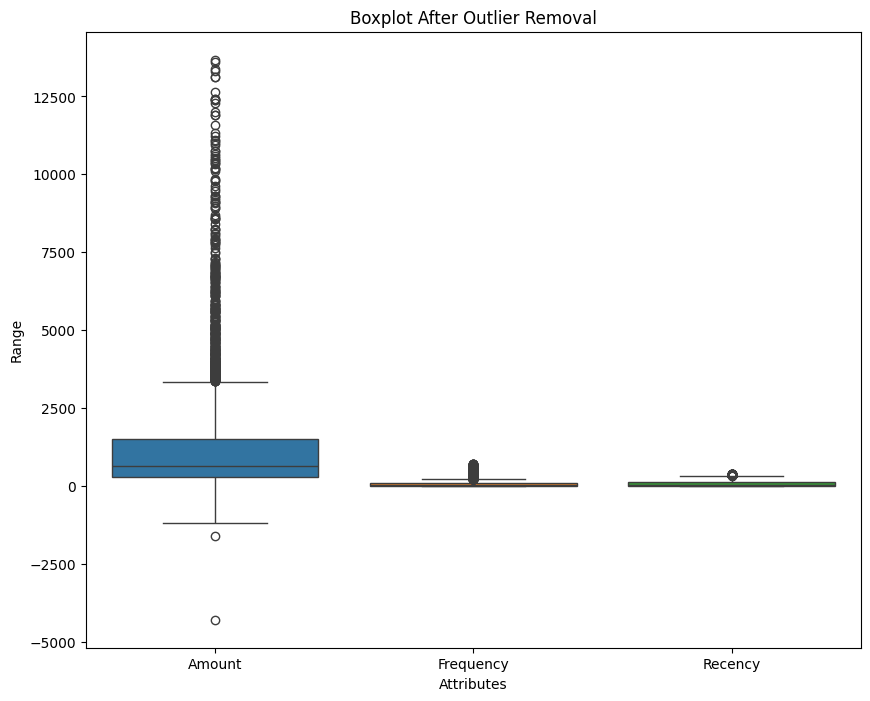

In [63]:
# Re-plot after outlier removal
plt.figure(figsize=(10, 8))
sns.boxplot(data=mdf[['Amount', 'Frequency', 'Recency']])
plt.title("Boxplot After Outlier Removal")
plt.ylabel("Range")
plt.xlabel("Attributes")
plt.show()

In [64]:
# Standardization
scal_df = mdf[['Amount', 'Frequency', 'Recency']]
scaler = StandardScaler()
mdf_scaled = scaler.fit_transform(scal_df)

In [65]:

print("\nShape of scaled data:", mdf_scaled.shape)


Shape of scaled data: (4293, 3)


In [66]:
# Elbow Method to Determine Optimal Number of Clusters
ec = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(mdf_scaled)
    ec.append(kmeans.inertia_)

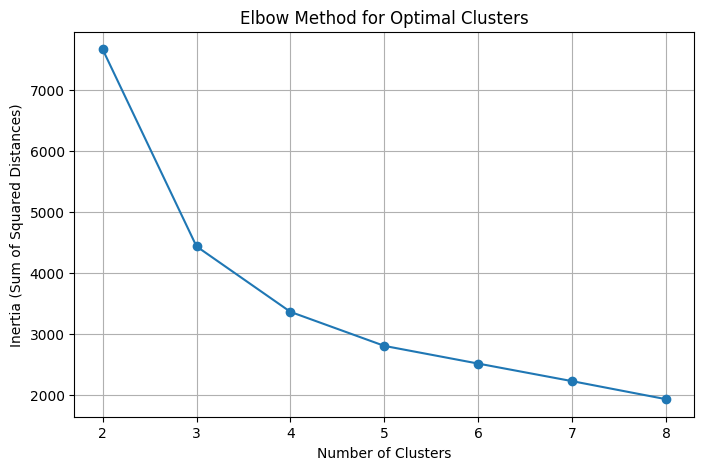

In [67]:
# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, ec, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid()
plt.show()

In [68]:
# KMeans Clustering
optimal_clusters = 3  # Based on Elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, max_iter=50, random_state=42)
kmeans.fit(mdf_scaled)

KMeans(max_iter=50, n_clusters=3, random_state=42)

In [73]:
# Check cluster number
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [74]:
# Assigning Cluster Labels
mdf['Cluster'] = kmeans.labels_
print("\nCluster assignment:\n")
print(mdf.head())


Cluster assignment:

  CustomerID   Amount  Frequency  Recency_x  Recency_y              Diff  \
0    12346.0     0.00          2        325        325 325 days 02:33:00   
1    12347.0  4310.00        182          1          1   1 days 20:58:00   
2    12348.0  1797.24         31         74         74  74 days 23:37:00   
3    12349.0  1757.55         73         18         18  18 days 02:59:00   
4    12350.0   334.40         17        309        309 309 days 20:49:00   

   Recency  Cluster  
0      325        2  
1        1        1  
2       74        0  
3       18        0  
4      309        2  


### Cluster Visualization

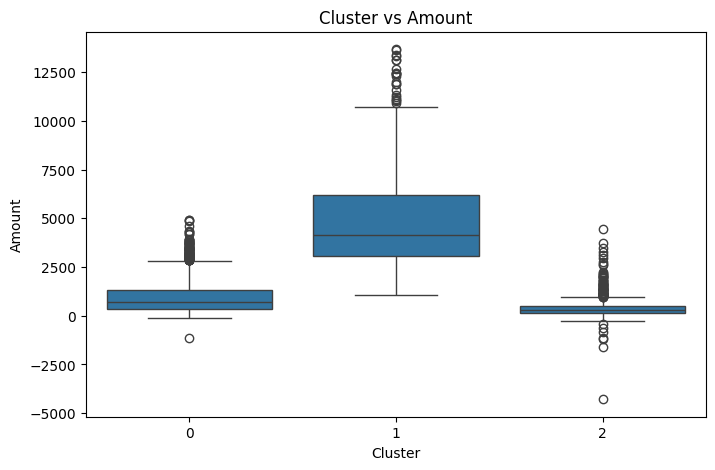

In [75]:
# Boxplot for Amount by Cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cluster', y='Amount', data=mdf)
plt.title("Cluster vs Amount")
plt.show()

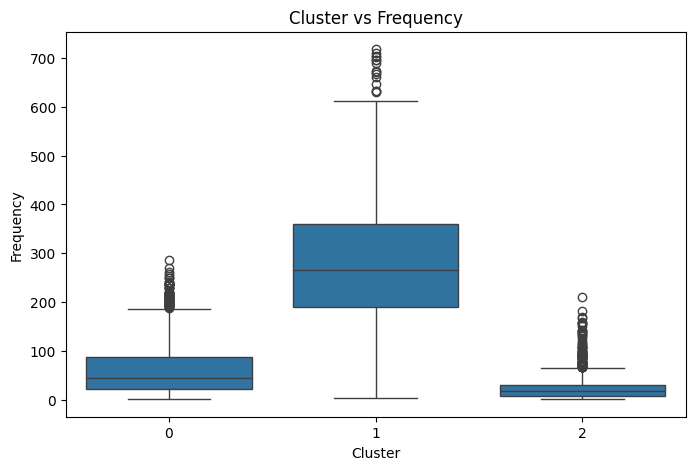

In [76]:
# Boxplot for Frequency by Cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cluster', y='Frequency', data=mdf)
plt.title("Cluster vs Frequency")
plt.show()

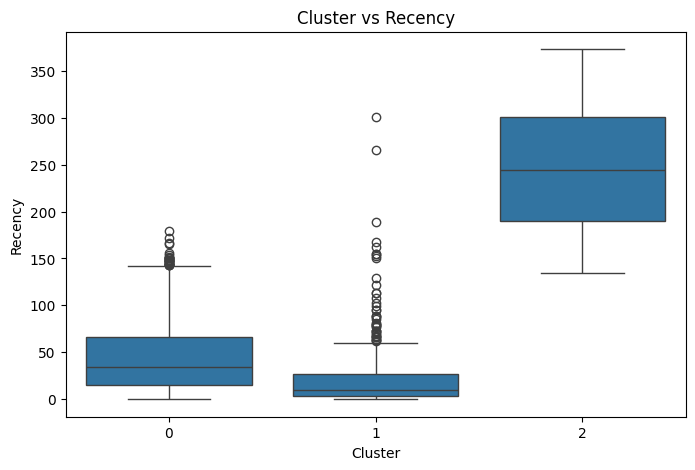

In [77]:
# Boxplot for Recency by Cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cluster', y='Recency', data=mdf)
plt.title("Cluster vs Recency")
plt.show()

<Axes: xlabel='Cluster', ylabel='Recency'>

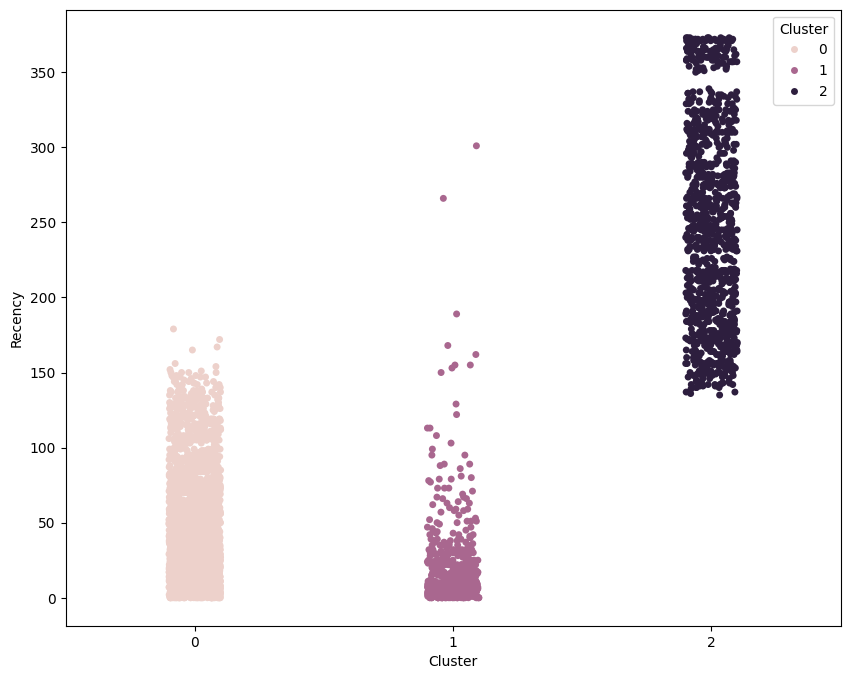

In [78]:
sns.stripplot(x='Cluster', y='Recency', data=mdf, hue='Cluster')


### Implement PCA for dimensionality reduction

In [81]:
# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(mdf_scaled)

In [82]:
# Adding PCA results to the DataFrame
mdf['PCA1'] = pca_data[:, 0]
mdf['PCA2'] = pca_data[:, 1]


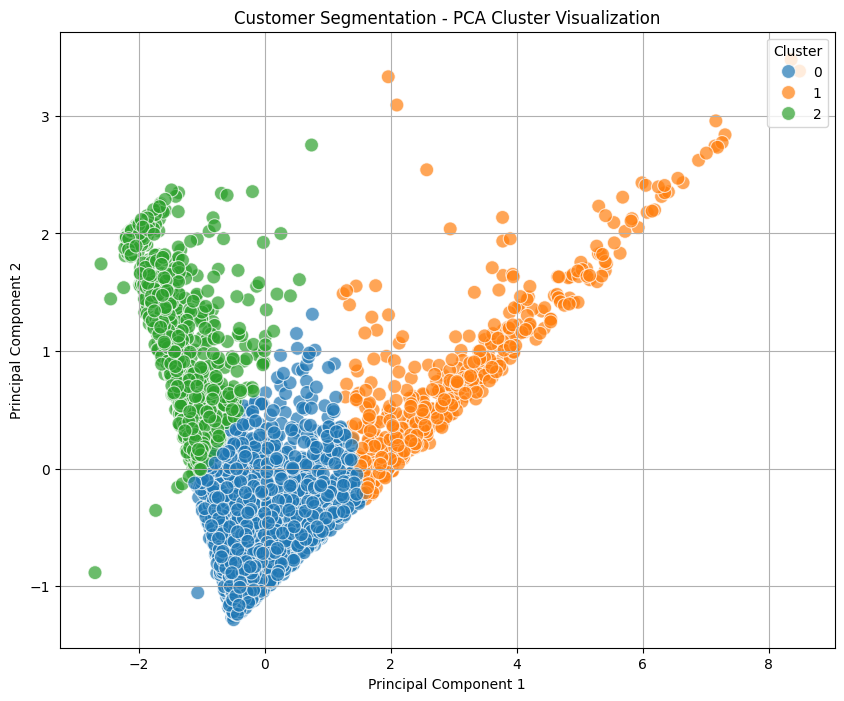

In [83]:
# Scatter plot of clusters in 2D PCA space
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', 
    y='PCA2', 
    hue='Cluster', 
    data=mdf, 
    palette='tab10', 
    s=100, 
    alpha=0.7
)
plt.title("Customer Segmentation - PCA Cluster Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()
